In [1]:
import itertools
import os

import equinox as eqx
import jax
import jax.numpy as jnp
import jax.random as jr
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from flowjax.distributions import Normal

from softcvi_validation import utils
from softcvi_validation.bnn import AdditiveBayesianMLP
from softcvi_validation.bnn.bnn_tasks import BNNRegressionProblem

os.chdir(utils.get_abspath_project_root())
plt.style.use('./plots/style.mplstyle')
palette = utils.get_palette()

loss_names=("SoftCVI(a=0.75)", "SoftCVI(a=1)", "SNIS-fKL", "ELBO") 
width_sizes=(50, 100)
seeds=range(10)
learning_rates=(5e-5, 1e-4, 5e-4, 1e-3)


results = {
    "method": [],
    "nn_width": [],
    "learning_rate": [],
    "test_set_log_likelihood": [],
    "mean_prediction_iqr": [],
    "mean_iqr_coverage": [],
    "val_log_likelihood": [],
}

for seed, loss_name, width, lr in itertools.product(
    seeds, loss_names, width_sizes, learning_rates,
    ):
    f_name = f"./results/bnn_results/seed={seed}_loss_name={loss_name}_width_size={width}_learning_rate={lr}.npz"
    metrics = dict(np.load(f_name))
    results["method"].append(loss_name)
    results["nn_width"].append(width)
    results["learning_rate"].append(lr)
    results["test_set_log_likelihood"].append(metrics["test_set_log_likelihood"])
    results["val_log_likelihood"].append(max(metrics["val_log_likelihood"]))
    results["mean_prediction_iqr"].append(metrics["mean_prediction_iqr"])
    results["mean_iqr_coverage"].append(metrics["mean_iqr_coverage"])

In [2]:
df = pd.DataFrame(results)
best_lr = df.loc[df.groupby(['method', 'nn_width'])['val_log_likelihood'].idxmax()]
best_lr = best_lr[['method', 'nn_width', 'learning_rate', 'val_log_likelihood']]
best_lr = best_lr.rename(columns={'learning_rate': 'best_learning_rate', 'val_log_likelihood': 'best_val_log_likelihood'})

df = df.drop(columns="val_log_likelihood")
df_av = df.groupby(["method", "nn_width", "learning_rate"]).mean() # Across seeds
df_se = df.groupby(["method", "nn_width", "learning_rate"]).sem()

In [3]:
def filter_to_best_lr(df, best_lr):
    df = pd.merge(
        df,
        best_lr[['method', 'nn_width', 'best_learning_rate']],
        left_on=['method', 'nn_width', 'learning_rate'],
        right_on=['method', 'nn_width', 'best_learning_rate'],
    )
    df = df.drop(columns=['best_learning_rate'])
    return df.set_index("method")

In [4]:
filter_to_best_lr(df_av, best_lr)

,nn_width,test_set_log_likelihood,mean_prediction_iqr,mean_iqr_coverage
method,,,,
ELBO,50,-2.391867,0.648227,0.2615
ELBO,100,-2.391655,0.641477,0.264
SNIS-fKL,50,-2.422223,0.695114,0.1864
SNIS-fKL,100,-2.421474,0.938051,0.2558
SoftCVI(a=0.75),50,-2.423882,0.743067,0.2022
SoftCVI(a=0.75),100,-2.422805,0.982792,0.2706
SoftCVI(a=1),50,-2.421527,0.700853,0.1897
SoftCVI(a=1),100,-2.423032,0.94316,0.2597


In [5]:
filter_to_best_lr(df_se, best_lr)

,nn_width,test_set_log_likelihood,mean_prediction_iqr,mean_iqr_coverage
method,,,,
ELBO,50,0.004730,0.083860,0.041810
ELBO,100,0.005170,0.065276,0.030612
SNIS-fKL,50,0.007086,0.010960,0.008067
SNIS-fKL,100,0.005262,0.010482,0.007471
SoftCVI(a=0.75),50,0.007151,0.018010,0.008875
SoftCVI(a=0.75),100,0.005156,0.016969,0.009614
SoftCVI(a=1),50,0.006994,0.012219,0.008834
SoftCVI(a=1),100,0.005112,0.011833,0.008664


In [6]:

def make_dummy(width):
    additive_mlp_kwargs = {
        "width_size": width,
        "depth": 1,
        "key": jr.key(0),
        "use_final_bias": False,
        "covariate_dim": 10,
    }
    return AdditiveBayesianMLP(
        param_to_distribution=lambda p: Normal(p, 0.02),
        **additive_mlp_kwargs,
    )

width = 50
seed = 0
dummy = make_dummy(width)
results = {}

for loss_name in loss_names:
    lr=best_lr[(best_lr["method"] == loss_name) & (best_lr["nn_width"] == width)]["best_learning_rate"].item()
    print(loss_name, lr)
    f_name = f"./results/bnn_results/seed={seed}_loss_name={loss_name}_width_size={width}_learning_rate={lr}.eqx"
    results[loss_name] = eqx.tree_deserialise_leaves(f_name, like=dummy)


SoftCVI(a=0.75) 5e-05
SoftCVI(a=1) 5e-05
SNIS-fKL 5e-05
ELBO 5e-05


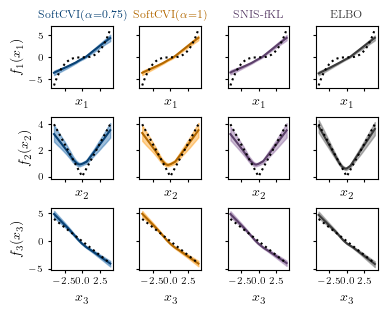

In [7]:
task = BNNRegressionProblem()
num_components = 3

fig = plt.figure(
        figsize=(0.7*plt.rcParams["figure.figsize"][0], 0.55*plt.rcParams["figure.figsize"][0]),
        layout="constrained",
)

axes = fig.subplots(
    ncols=len(loss_names),
    nrows=num_components,
    sharex=True,
    sharey="row",
    )
key = jr.key(0)

for ((loss_name, bamlp), ax_col) in zip(results.items(), axes.T, strict=True):


    def sample_additive_components(key, bamlp, x, n=200):

        def _sample_single(key): 
            amlp = bamlp.sample(key)
            return eqx.filter_vmap(amlp.additive_components)(x)
        
        return jax.lax.map(_sample_single, jr.split(key, n))
    
    xs = jnp.stack(
        [jnp.linspace(-4, 4, 200) for _ in range(task.dim)],
        axis=1,
        )

    components = []
    key, subkey = jr.split(key)
    components = sample_additive_components(subkey, bamlp, xs)
    ground_truth = task.underlying_additive(xs)

    for i in range(num_components):
        c = components[:, :, i]

        # Center to avoid visualising differences from indeterminate biases
        gt_mean = ground_truth[:, i].mean()

        comp_mean = components.mean(axis=0)  # Average over BNN samples
        c = c - c.mean() + ground_truth[:, i].mean()

        ax_col[i].fill_between(
            xs[:, i],
            jnp.quantile(c, q=0.025, axis=0),
            jnp.quantile(c, q=0.975, axis=0),
            alpha=0.4,
            label="95% prediction interval",
            color=palette[loss_name],
            )
                
        ax_col[i].plot(
            xs[:, i], c.mean(axis=0),
            color=utils.darken_color(palette[loss_name]),
            )
        ax_col[i].plot(
            xs[:, i],
            ground_truth[:, i],
            color="black",
            linestyle="dotted",
        )

for loss_name, ax in zip(results.keys(), axes[0], strict=True):
    ax.set_title(
        loss_name.replace("a", r"$\alpha$"),
        font={"size": 8},
        color=utils.darken_color(palette[loss_name]),
        )

for i, ax in enumerate(axes.T[0]):
    ax.set_ylabel(fr"$f_{i+1}(x_{i+1})$")

for i, row in enumerate(axes):
    [ax.set_xlabel(fr"$x_{i+1}$") for ax in row]

for ax in axes.ravel():
    ax.set_box_aspect(1)

fig.savefig("plots/plots/bnn_components.pdf")


In [8]:
def count_params(tree):
    leaves = jax.tree_util.tree_leaves(eqx.filter(tree, eqx.is_inexact_array))
    return sum(leaf.size for leaf in leaves)

for w in [50, 100]:
    print(f"w={w}, parameters={count_params(make_dummy(w))//2}")

w=50, parameters=1500
w=100, parameters=3000
